In [1]:
# importing the necessary libraries:
import warnings
warnings.filterwarnings("ignore")
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scrublet as scr
import leidenalg
from scipy import sparse as sp

In [2]:
# Load the first AnnData object
adata1 = sc.read_h5ad('wound_with_annotation.h5ad')
print("Layers:", list(adata1.layers.keys()))

Layers: ['counts']


In [3]:
raw = adata1.layers["counts"]

print("Shape:", raw.shape)
print("Data type:", raw.dtype)

# basic stats
print("Min:", raw.min(), "Max:", raw.max())

# mean and median library size per cell
cell_sums = np.array(raw.sum(axis=1)).flatten()
print("Per-cell counts: min", cell_sums.min(), 
      "median", np.median(cell_sums), 
      "max", cell_sums.max())

# check first few rows (genes per cell)
print("First few entries:\n", raw[:5, :5].toarray() if hasattr(raw, "toarray") else raw[:5, :5])

Shape: (16225, 25223)
Data type: int64
Min: 0 Max: 3630
Per-cell counts: min 1000 median 3897.0 max 38725
First few entries:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


*Start from raw counts, normalise and log1p like the tumour data and then keep a copy in layers for reference*

In [4]:
adata1.X = adata1.layers["counts"].copy()

In [5]:
adata1.X.max()

3630

In [6]:
sc.pp.normalize_total(adata1, target_sum = 1e4)

In [7]:
adata1.layers["counts"].max()

3630

In [8]:
sc.pp.log1p(adata1)

In [9]:
adata1.X.max()

8.429609

In [10]:
adata1.layers["log1p"] = adata1.X.copy()

In [11]:
print("Layers:", list(adata1.layers.keys()))

Layers: ['counts', 'log1p']


In [12]:
# Checking if the .X is normalised and log1p
X = adata1.X
if not isinstance(X, np.ndarray):
    X = X.toarray()[:1000]  # take subset if sparse to avoid memory blow-up
else:
    X = X[:1000]

print("Min:", X.min(), "Max:", X.max(), "Mean:", X.mean())

Min: 0.0 Max: 8.131547 Mean: 0.08743701


In [13]:
# adding Wound prefix to wound time_point
wound_map = {
    "24hr": "Wound_24hr",
    "7day": "Wound_7day",
    "Blood": "Wound_blood"
}
adata1.obs["time_point"] = adata1.obs["time_point"].map(wound_map).astype("category")

print(adata1.obs["time_point"].unique())

['Wound_24hr', 'Wound_7day', 'Wound_blood']
Categories (3, object): ['Wound_24hr', 'Wound_7day', 'Wound_blood']


In [14]:
# 1) Subset to neutrophils (boolean mask) + make a copy to avoid view warnings
mask = adata1.obs["cell_type"].astype(str).eq("Neutrophils")
adata1_neutro = adata1[mask].copy()

# 2) Clean up unused categories (optional but nice)
if "cell_type" in adata1_neutro.obs and str(adata1_neutro.obs["cell_type"].dtype) == "category":
    adata1_neutro.obs["cell_type"] = adata1_neutro.obs["cell_type"].cat.remove_unused_categories()
print(adata1_neutro.shape)

(11036, 25223)


In [15]:
# Load the second AnnData object
adata2 = sc.read_h5ad('tumour_with_annotation.h5ad')
print("Layers:", list(adata2.layers.keys()))

Layers: ['X_detected', 'X_preNorm', 'X_scaled_normalised']


In [16]:
adata2.layers["log1p"] = adata2.layers["X_preNorm"]

np.expm1(adata) is the opposite of sc.pp.log1p(adata)

In [17]:
adata2.layers["normalised"] = np.expm1(adata2.layers["log1p"])

Making a copy of your "normalised" layer and saves it as "counts"; So at this point, "counts" is identical to "normalised".
Loops over every cell (row index i).

For each cell i:Takes its row from "counts" (which currently contains normalised values).Multiplies that row by the cell’s total_counts (from adata2.obs["total_counts"]).

This “undoes” the normalisation → reconstructs something closer to the original raw counts.

In [18]:
adata2.layers["counts"] = adata2.layers["normalised"].copy()
for i in range(adata2.shape[0]):
    print(i, "/", adata2.shape[0], end="\r")
    adata2.layers["counts"][i] = adata2.layers["counts"][i] * adata2.obs["total_counts"].values[i]
print("done")

done7 / 35968


In [19]:
print("Layers:", list(adata2.layers.keys()))

Layers: ['X_detected', 'X_preNorm', 'X_scaled_normalised', 'log1p', 'normalised', 'counts']


In [20]:
print(adata2.layers['counts'].toarray().min())
print(adata2.layers['counts'].toarray().max())
print(adata2.layers['counts'].toarray().mean())

0.0
25320006.0
3161.346


In [21]:
raw = adata2.layers["counts"]

print("Shape:", raw.shape)
print("Data type:", raw.dtype)

# basic stats
print("Min:", raw.min(), "Max:", raw.max())

# mean and median library size per cell
cell_sums = np.array(raw.sum(axis=1)).flatten()
print("Per-cell counts: min", cell_sums.min(), 
      "median", np.median(cell_sums), 
      "max", cell_sums.max())

# check first few rows (genes per cell)
print("First few entries:\n", raw[:5, :5].toarray() if hasattr(raw, "toarray") else raw[:5, :5])

Shape: (35968, 23279)
Data type: float32
Min: 0.0 Max: 25320006.0
Per-cell counts: min 20009998.0 median 54685000.0 max 398720000.0
First few entries:
 [[80000.01      0.        0.        0.        0.   ]
 [20009.975     0.        0.        0.        0.   ]
 [10001.9       0.        0.        0.        0.   ]
 [10000.527     0.        0.        0.        0.   ]
 [10000.        0.        0.        0.        0.   ]]


In [22]:
adata2.shape

(35968, 23279)

In [23]:
print(adata2.obs['total_counts'].min())
print(adata2.obs['total_counts'].max())

2001.0
39872.0


In [24]:
# Checking if the .X is normalised and log1p
print(adata2.layers['X_preNorm'].toarray().min())
print(adata2.layers['X_preNorm'].toarray().max())
print(adata2.layers['X_preNorm'].toarray().mean())

0.0
7.934989
0.116148844


In [25]:
adata2.layers["log1p"] = adata2.layers["X_preNorm"].copy()
print("Layers:", list(adata2.layers.keys()))
adata2.X = adata2.layers["log1p"].copy()

Layers: ['X_detected', 'X_preNorm', 'X_scaled_normalised', 'log1p', 'normalised', 'counts']


In [26]:
batch_map = { 
    "Control_24hr": "Control_24hr", 
    "Control_72hr": "Control_72hr", 
    "Stimulated_24hr": "Stimulated_24hr",
    "Stimulated_72hr": "Stimulated_72hr",
    "Blood": "Tumour_blood",
    "Resting": "Unmanipulated"
}
adata2.obs["batch"] = adata2.obs["batch"].map(batch_map).astype("category") 
print(adata2.obs["batch"].unique())

['Control_24hr', 'Stimulated_24hr', 'Unmanipulated', 'Tumour_blood', 'Control_72hr', 'Stimulated_72hr']
Categories (6, object): ['Tumour_blood', 'Control_24hr', 'Control_72hr', 'Unmanipulated', 'Stimulated_24hr', 'Stimulated_72hr']


In [27]:
# 1) Subset to neutrophils (boolean mask) + make a copy to avoid view warnings
mask = adata2.obs["cell_type"].astype(str).eq("Neutrophils")
adata2_neutro = adata2[mask].copy()

# 2) Clean up unused categories (optional but nice)
if "cell_type" in adata2_neutro.obs and str(adata2_neutro.obs["cell_type"].dtype) == "category":
    adata2_neutro.obs["cell_type"] = adata2_neutro.obs["cell_type"].cat.remove_unused_categories()
print(adata2_neutro.shape)

(24029, 23279)


In [28]:
# Concatenating the 2 datasets

adata1_neutro.obs['sample'] = 'Wound'
adata2_neutro.obs['sample'] = 'Tumour'

combined = sc.concat([adata1_neutro, adata2_neutro], axis=0, join='outer')

In [29]:
print(f"Combined dataset shape: {combined.shape}")
print('wound:' , adata1_neutro.shape)
print('tumour:', adata2_neutro.shape)

Combined dataset shape: (35065, 27429)
wound: (11036, 25223)
tumour: (24029, 23279)


In [30]:
print("Samples:", combined.obs["sample"].unique())
print("Batches:", combined.obs["batch"].unique())
print("Time points:", combined.obs["time_point"].unique())

Samples: ['Wound' 'Tumour']
Batches: [NaN, 'Control_24hr', 'Stimulated_24hr', 'Unmanipulated', 'Tumour_blood', 'Control_72hr', 'Stimulated_72hr']
Categories (6, object): ['Tumour_blood', 'Control_24hr', 'Control_72hr', 'Unmanipulated', 'Stimulated_24hr', 'Stimulated_72hr']
Time points: ['Wound_24hr', 'Wound_7day', 'Wound_blood', NaN]
Categories (3, object): ['Wound_24hr', 'Wound_7day', 'Wound_blood']


In [31]:
combined.write('../data/from_arnolda/merged_neu.h5ad')

In [32]:
merged_neu = sc.read_h5ad('../data/from_arnolda/merged_neu.h5ad')

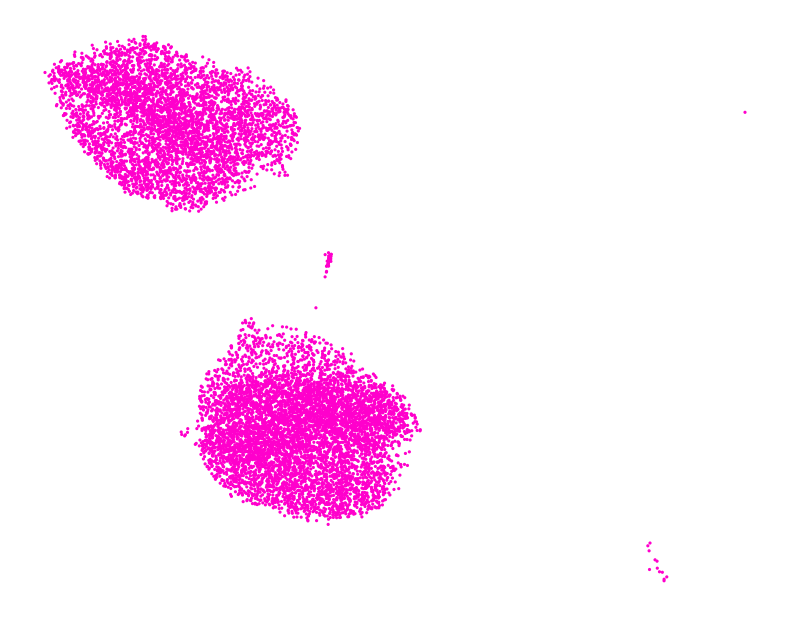

In [33]:
palette= {"Neutrophils": "#FF00CC"}
fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.umap(
    adata1_neutro, 
    color=['cell_type'], 
    ax=ax, 
    palette=palette, 
    add_outline=False, 
    show=False,
    size=21,
    legend_loc=None
    #legend_fontsize=16,       # Legend font size
    #legend_fontoutline=2.0    # Optional: make font outline for better visibility
)

ax.set(xlabel="", ylabel="")
ax.set_axis_off()
ax.title.set_visible(False)
ax.set_aspect(1.0)
fig.tight_layout()
ax = plt.gca()
leg = ax.get_legend()

if leg is not None:
    for handle in leg.legendHandles:
        handle.set_sizes([50])   # make legend markers bigger
plt.show()

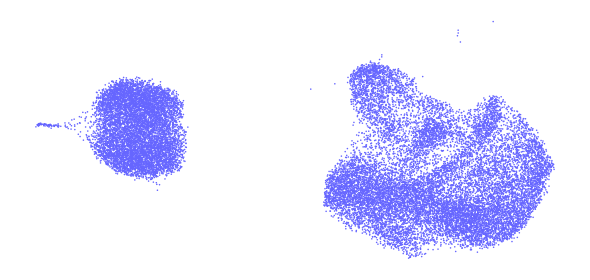

In [80]:
palette= {"Neutrophils": "#6666FF"}
fig, ax = plt.subplots(figsize=(6,6))
sc.pl.umap(
    adata2_neutro, 
    color=['cell_type'], 
    ax=ax, 
    palette=palette, 
    add_outline=False, 
    show=False,
    size=5,
    legend_loc=None,
    legend_fontsize=14,       # Legend font size
    legend_fontoutline=2.0    # Optional: make font outline for better visibility
)

ax.set(xlabel="", ylabel="")
ax.set_axis_off()
ax.title.set_visible(False)
ax.set_aspect(1.0)
fig.tight_layout()
ax = plt.gca()
leg = ax.get_legend()

if leg is not None:
    for handle in leg.legendHandles:
        handle.set_sizes([50])   # make legend markers bigger
plt.show()

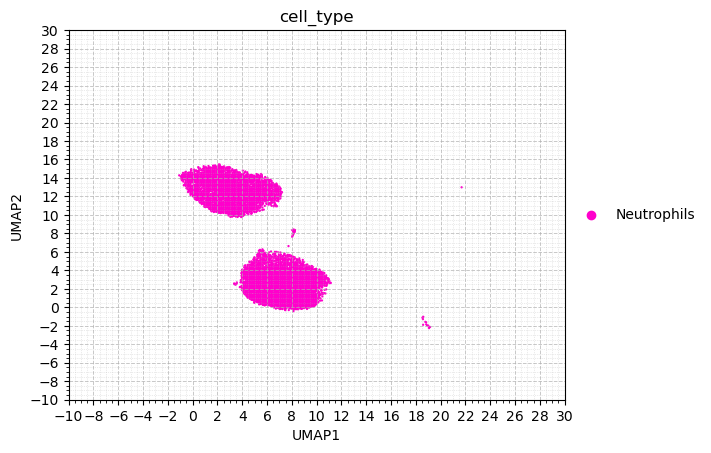

In [35]:
ax = sc.pl.umap(
    adata1_neutro,
    color="cell_type",
    show=False,      # prevent auto-show
    return_fig=False # return the matplotlib axis instead of a figure
)

# Add gridlines
ax.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Set axis limits explicitly (adjust to your preferred range)
ax.set_xlim(-10, 30)
ax.set_ylim(-10, 30)

# Set tick marks (e.g. every 1 unit)
ax.set_xticks(range(-10, 31, 2))
ax.set_yticks(range(-10, 31, 2))

# Axis labels
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")

plt.show()

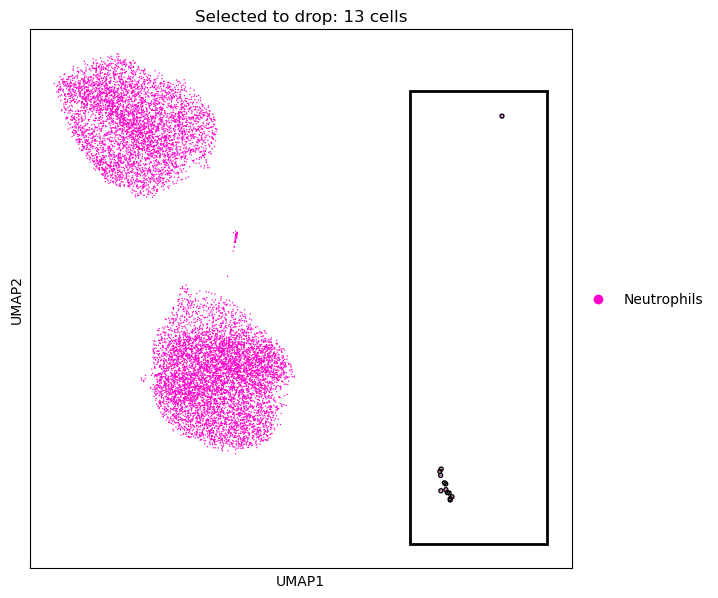

Removing cells: 13
Shapes: (11036, 25223) -> (11023, 25223)


In [36]:
from matplotlib.patches import Rectangle
A = adata1_neutro
# ---- 1) Rectangular gate around the pink-circled blob ----
XY = A.obsm["X_umap"][:, :2]
x, y = XY[:, 0], XY[:, 1]

# Bounds read off your plot (tweak slightly if you miss/overcatch a few points)
x0, x1 = 17, 24
y0, y1 =   -4, 14

rect_mask = (x >= x0) & (x <= x1) & (y >= y0) & (y <= y1)


to_drop = rect_mask

# ---- 2) Visual sanity check before removing ----
fig, ax = plt.subplots(figsize=(7, 7))
sc.pl.umap(A, color="cell_type", ax=ax, show=False, size=4)
ax.add_patch(Rectangle((x0, y0), x1-x0, y1-y0, fill=False, linewidth=2))
ax.scatter(x[to_drop], y[to_drop], s=8, facecolors='none', edgecolors='k')
ax.set_title(f"Selected to drop: {int(to_drop.sum())} cells")
plt.show()

# ---- 3) Drop & copy ----
print("Removing cells:", int(to_drop.sum()))
filtered = A[~to_drop].copy()
print("Shapes:", A.shape, "->", filtered.shape)

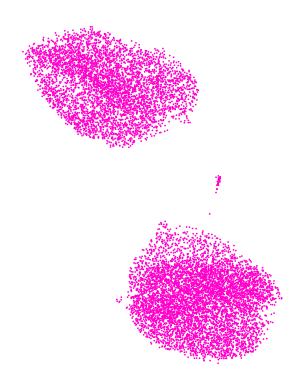

In [82]:
palette= {"Neutrophils": "#FF00CC"}
fig, ax = plt.subplots(figsize=(4,4))
sc.pl.umap(
    filtered, 
    color=['cell_type'], 
    ax=ax, 
    palette=palette, 
    add_outline=False, 
    show=False,
    size=6,
    legend_loc=None,
    #legend_fontsize=14,       # Legend font size
    #legend_fontoutline=2.0    # Optional: make font outline for better visibility
)

ax.set(xlabel="", ylabel="")
ax.set_axis_off()
ax.title.set_visible(False)
ax.set_aspect(1.0)
fig.tight_layout()
ax = plt.gca()
leg = ax.get_legend()

if leg is not None:
    for handle in leg.legendHandles:
        handle.set_sizes([50])   # make legend markers bigger
plt.show()

In [45]:
adata2_neutro

AnnData object with n_obs × n_vars = 24029 × 23279
    obs: 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'log10_total_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'Leiden_start_cluster_0.1_opt_sc', 'Leiden_start_cluster_0.4_opt_sc', 'Leiden_start_cluster_0.7_opt_sc', 'Leiden_start_cluster_1_opt_sc', 'Leiden_start_cluster_1.3_opt_sc', 'Leiden_start_cluster_1.5_opt_sc', 'Leiden_start_cluster_1.8_opt_sc', 'Leiden_start_cluster_2.5_opt_sc', 'cell_type', 'sample'
    var: 'Ensembl', 'GeneSymbol', 'Description', 'Biotype', 'HumanEnsemblID', 'HumanGeneSymbol', 'EntrezID', 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', '

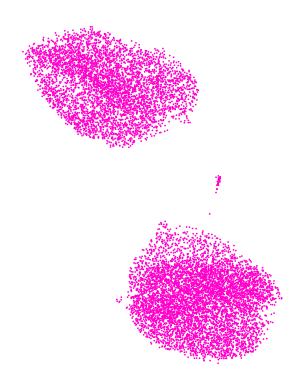

In [79]:
palette = {"Neutrophils": "#FF00CC"}
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(
    filtered, 
    color="cell_type", 
    palette=palette, 
    ax=ax, 
    add_outline=False, 
    show=False,
    size=6,
    legend_loc=None,
    #legend_fontsize=16,
    #legend_fontoutline=2.0
)

ax.set(xlabel="", ylabel="")
ax.set_axis_off()
ax.title.set_visible(False)
ax.set_aspect(1.0)
fig.tight_layout()

# --- Change legend label ---
leg = ax.get_legend()
#if leg is not None:
    #leg.texts[0].set_text("Wound")   # rename first entry

plt.show()

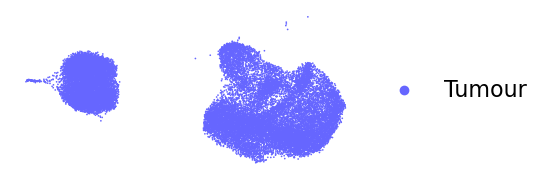

In [76]:
palette= {"Neutrophils": "#6666FF"}
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.umap(
    adata2_neutro, 
    color=['cell_type'], 
    ax=ax, 
    palette=palette, 
    add_outline=False, 
    show=False,
    size=6,
    #legend_loc=None,
    legend_fontsize=16,       # Legend font size
    legend_fontoutline=2.0    # Optional: make font outline for better visibility
)

ax.set(xlabel="", ylabel="")
ax.set_axis_off()
ax.title.set_visible(False)
ax.set_aspect(1.0)
fig.tight_layout()
# --- Change legend label ---
leg = ax.get_legend()
if leg is not None:
    leg.texts[0].set_text("Tumour")   # rename first entry

plt.show()
